# Sandbox

### Just a simple notebook that can be used to try out some ideas/simulations

In [1]:
import numpy as np
import helper_fcns as hfunc
import model_responses as mod_resp
from scipy.stats.mstats import gmean
from scipy.stats import norm as gaussNorm
import autoreload
import matplotlib.pyplot as plt
#plt.style.use('paul_plt_style.mplstyle')
import matplotlib.backends.backend_pdf as pltSave
import seaborn as sns
%matplotlib inline

base_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/';
# V1 data - original
# save_loc = base_loc + 'Analysis/Figures'; # local
data_loc = base_loc + 'Analysis/Structures/'; # local
# V1 data - alt exp
# save_loc = base_loc + 'altExp/analysis/figures'; # local
# data_loc = base_loc + 'altExp/analysis/structures/'; # local
# LGN data - m675
# save_loc = base_loc + 'LGN/analysis/figures'; # local
# data_loc = base_loc + 'LGN/analysis/structures/'; # local

save_loc = base_loc + 'common/figures/'

# fitName      = 'fitList_181115_wght_modPoiss.npy'; # LGN
fitName      = 'fitList_181015_wght_sqrt.npy'; # V1
# fitName      = 'fitList_180717_wght_modPoiss.npy'; # V1 alt exp
expName      = 'dataList.npy';
descrName    = 'descrFits.npy';
descrModName = 'descrFitsModel.npy';
respName     = 'respAboveBase.npy';

# ADJUST
whichCell = 1;
expInd = 1; # 1 - og V1; 2 - altExp V1; 3 - og LGN
normType = 2; # wght (gaussian)

# FIXED
muLoc = 0; # mu [prefSf] is in location '0' of parameter arrays
dOrdLoc = 1;

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 25
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

Load data, model fits

In [3]:
dataList = np.load(data_loc + expName, encoding='latin1').item();
cellStruct = np.load(data_loc + dataList['unitName'][whichCell-1] + '_sfm.npy', encoding='latin1').item()

In [4]:
modParams = np.load(data_loc + fitName, encoding='latin1').item();

In [5]:
currParams = modParams[whichCell-1]['params']

## Evaluate gaussian-weighting normalization

First, just recapitulating the calculations that determine the SF filters, i.e. hfunc.getInhSfTuning() just redone here

In [ ]:
omega = np.logspace(-2, 2, 1000); # frequencies to test

In [ ]:
# Compute suppressive SF tuning                                                                                                                                                                                                                                           
# The exponents of the filters used to approximately tile the spatial frequency domain                                                                                                                                                                                    
n = np.array([.75, 1.5]);
# The number of cells in the broad/narrow pool                                                                                                                                                                                                                            
nUnits = np.array([12, 15]);
# The gain of the linear filters in the broad/narrow pool                                                                                                                                                                                                                 
gain = np.array([.57, .614]);

normPool = {'n': n, 'nUnits': nUnits, 'gain': gain};
# Get filter properties in spatial frequency domain                                                                                                                                                                                                                       
gain = np.empty((len(normPool.get('n'))));
for iB in range(len(normPool.get('n'))):
    prefSf_new = np.logspace(np.log10(.1), np.log10(30), normPool.get('nUnits')[iB]);
    if iB == 0:
        prefSf = prefSf_new;
    else:
        prefSf = [prefSf, prefSf_new];
    gain[iB]   = normPool.get('gain')[iB];

In [ ]:
for iB in range(len(normPool.get('n'))):
    sfRel = np.matlib.repmat(omega, len(prefSf[iB]), 1).transpose() / prefSf[iB]
    s     = np.power(np.matlib.repmat(omega, len(prefSf[iB]), 1).transpose(), normPool['n'][iB]) \
                * np.exp(-normPool['n'][iB]/2 * np.square(sfRel));
    sMax  = np.power(prefSf[iB], normPool['n'][iB]) * np.exp(-normPool['n'][iB]/2);
    if iB == 0:
        selSf = gain[iB] * s / sMax;
    else:
        selSf = [selSf, gain[iB] * s/sMax];

Plot some filters

In [ ]:
sns.set_style('ticks')
pool_name = ['broad', 'narrow']
f, ax = plt.subplots(1, 2, figsize=(10, 2))

plotWeighting = 0;

# gauss filter - how wide will the weighting be?
mu = 1.5;
sig = 5e-1;

for i in range(2):
    
    for j in range(selSf[i].shape[1]):
        ax[i].semilogx(omega, selSf[i][:, j])
        ax[i].set_title('%s pool' % pool_name[i])
#     a=plt.semilogx(omega, selSf[0][:, 6])[0];
#     b=plt.semilogx(omega, selSf[1][:, 3])[0];
#     c=plt.semilogx(omega, selSf[1][:, 13])[0];
#     plt.legend([a, b, c], ['broad filter', 'narrow low', 'narrow high']);

    ax[i].set_xlabel('spatial frequency (c/deg)')
    ax[i].set_ylabel('weight (a.u.)')

    if plotWeighting:
        filtWeighting = gaussNorm.pdf(omega, mu, sig);
        poolMax = np.max(selSf[i][:, 0])
        ax[i].semilogx(omega, poolMax*np.divide(filtWeighting, np.max(filtWeighting)), '--')

sns.despine(offset=10)

# now save
pdf = pltSave.PdfPages(str(save_loc + 'normPool.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

#### What is the (octave) bandwidth of each filter?

In [ ]:
height = 1/2.; # e.g. BW at half-height 
nPools = len(normPool['n'])
bw_oct = [];
for iB in range(nPools):
    nFilts = selSf[iB].shape[1];
    bw_oct.append(np.zeros((nFilts, 1)));
    for filt in range(selSf[iB].shape[1]):
        currFilt = selSf[iB][:, filt];
#         currFilt = np.square(selSf[iB][:, filt]);
        maxResp = np.max(currFilt);
        maxInd = np.argmax(currFilt);
        bw_ends = [np.argmin(np.square((maxResp*height - currFilt[0:maxInd]))), 
                   maxInd + np.argmin(np.square((maxResp*height - currFilt[maxInd:])))]
        bw_lin = omega[bw_ends];
        bw_oct[iB][filt] = hfunc.bw_lin_to_log(bw_lin[0], bw_lin[1])

In [ ]:
print('Octave bandwidth of broad pool: %s' %(str((np.unique(np.round(bw_oct[0], 2))))));
print('Octave bandwidth of narrow pool: %s' %(str((np.unique(np.round(bw_oct[1], 2))))));

#### Compute the normalization tuning given the filters from above

In [ ]:
normPool = cellStruct['sfm']['mod']['normalization']
normPref = normPool['pref']['sf'];
normResp = normPool['normResp'];
inhSfTuning = hfunc.getSuppressiveSFtuning(); # 1000 x 27...

#### Get model optimized weighting/tuning, plot

In [ ]:
gs_mean, gs_std = hfunc.getNormParams(currParams, normType=2)

In [ ]:
nInhChan = 2;
nTrials = inhSfTuning.shape[0];
normWeights = hfunc.genNormWeights(cellStruct, nInhChan, gs_mean, gs_std, 1000)
normWeights = normWeights[:, :, 0]; # each 3rd dim slice is the same, just take one

sfNormCurr = np.sum(.5*(normWeights*np.square(inhSfTuning)), 1);
sfNormTune = sfNormCurr/np.amax(np.abs(sfNormCurr));

In [ ]:
sfNormCurr = np.sum(.5*(normWeights*np.square(inhSfTuning)), 1);
sfNormTune = sfNormCurr/np.amax(np.abs(sfNormCurr));

In [ ]:
omega = np.logspace(-2, 2, 1000);
plt.semilogx([omega[0], omega[-1]], [0, 0], 'k--')
plt.semilogx([.01, .01], [-0.1, 1.1], 'k--')
plt.semilogx([.1, .1], [-0.1, 1.1], 'k--')
plt.semilogx([1, 1], [-0.1, 1.1], 'k--')
plt.semilogx([10, 10], [-0.1, 1.1], 'k--')
plt.semilogx([100, 100], [-0.1, 1.1], 'k--')
plt.ylim(-0.1, 1.3)
plt.ylabel('response (a.u.)')
plt.xlabel('spatial frequency (c/deg)')

tn = plt.semilogx(omega, sfNormTune, '-', linewidth=2);
plt.legend([tn[0]], ['mu = %.2f, std = %.2f' % (np.exp(gs_mean), gs_std)], loc='upper left', fontsize='x-small');

## How does this normalization interact with contrast?

Specifically, Tony asked for a comparison of the effect of changing the normalization constant and a spatial frequency-dependent normalization pool. Mathematically, $$R(\omega; \vec{\theta}) = \frac{f(\omega; \vec{\theta})}{\sigma^2 + N(\omega; \vec{\theta})}$$ where $f$ is the excitatory filter, $N$ is the (frequency-tuned) normalization pool, and $\sigma$ is the normalization constant. The optimized parameters $\vec{\theta}$ are fit per cell, and set the tuning for the excitatory and normalization mechanisms, as well as the overall response amplitude and non-linearity.

__The question, then, is at different frequencies, does a frequency-dependent $N$ have the same effect as changing $\sigma$?__

In [6]:
nSfs = 11;
nCons = 11;
sfSteps = np.geomspace(0.3, 10, nSfs)
conSteps = np.geomspace(0.01, 1, nCons)
disp = 1; # single gratings...

resps = np.nan * np.zeros((nSfs, nCons))

In [15]:
# let's adjust the normalization constant for a given SF, and see how the tuning changes
nC50_steps = 7;
c50_step = 0.25; # how large is each step as a fraction of the original c50 value?

c50_ind = 2;
c50_fit = currParams[c50_ind];
c50_steps = np.power(2, np.arange(-c50_step*np.floor(nC50_steps/2), c50_step*np.ceil(nC50_steps/2), c50_step));
respsC50 = np.nan * np.zeros((nC50_steps, nCons))

In [12]:
# get the (unaltered) simulated responses...
for sf_i in range(nSfs):
    for con_i in range(nCons):
        curr_resp, _, _, _, _  = mod_resp.SFMsimulate(currParams, cellStruct, stimFamily=disp, con=conSteps[con_i], sf_c=sfSteps[sf_i], unweighted=0, normType=normType, expInd=expInd)        
        resps[sf_i, con_i] = curr_resp[0]

In [16]:
# and now, with an adjusted normalization constant
# for an intermediate SF, we'll vary the 
adjParams = np.copy(currParams);
sfMid = sfSteps[int(np.floor(nSfs/2.0))]; # pick an intermediate SF
# with normType = -1, we'll just set asym = 0
for c50_i in range(nC50_steps):
    adjParams[c50_ind] = c50_fit * c50_steps[c50_i];
    for con_i in range(nCons):
        curr_resp, _, _, _, _  = mod_resp.SFMsimulate(adjParams, cellStruct, stimFamily=disp, con=conSteps[con_i], sf_c=sfMid, unweighted=0, normType=normType, expInd=expInd)        
        respsC50[c50_i, con_i] = curr_resp[0]

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


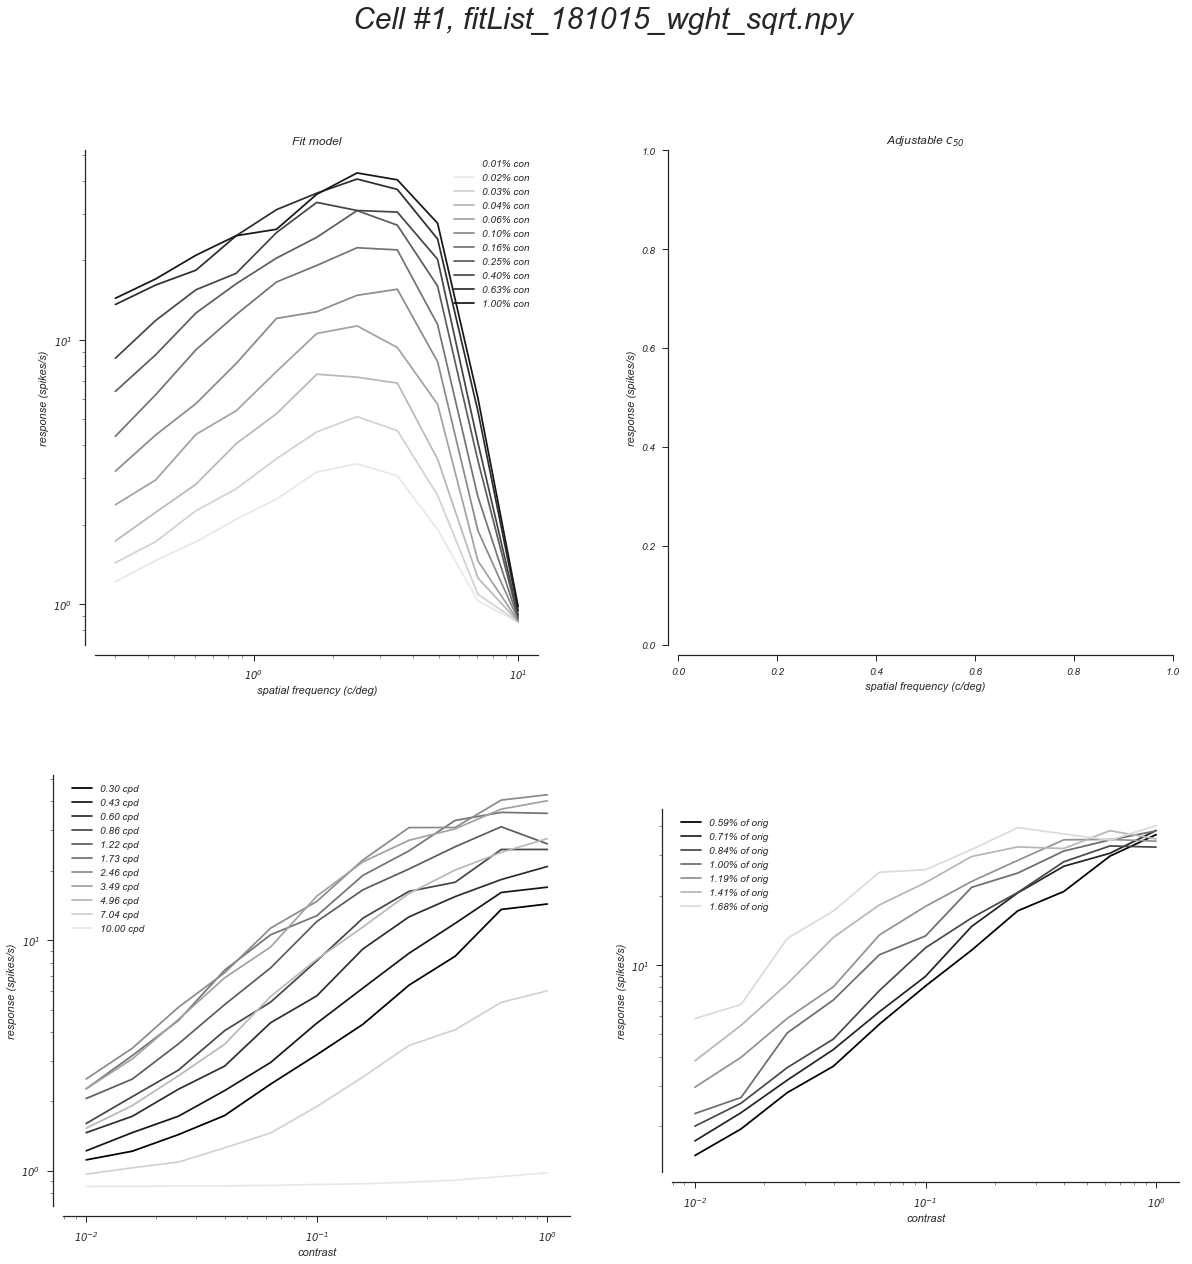

In [19]:
# now plot
sns.set_style('ticks')
rows = 2; cols = 2;
f, ax = plt.subplots(rows, cols, figsize=(10*rows, 10*cols))

# first, SF tuning
for con_i in range(nCons):
    col = [1-con_i/float(nCons), 1-con_i/float(nCons), 1-con_i/float(nCons)];
    # model fit
    ax[0, 0].loglog(sfSteps, resps[:, con_i], color=col, label='%.2f%% con' % conSteps[con_i])

# then, RVC
for sf_i in range(nSfs):
    col = [sf_i/float(nSfs), sf_i/float(nSfs), sf_i/float(nSfs)];
    # model fit
    ax[1, 0].loglog(conSteps, resps[sf_i, :], color=col, label='%.2f cpd' % sfSteps[sf_i])
        
# then, RVC with adjusted normalization constant
for c50_i in range(nC50_steps):
    col = [c50_i/float(nC50_steps), c50_i/float(nC50_steps), c50_i/float(nC50_steps)];
    ax[1, 1].loglog(conSteps, respsC50[c50_i, :], color=col, label=r'%.2f%% of orig' % c50_steps[c50_i])

ax[0, 0].set_title('Fit model')
ax[0, 1].set_title(r'Adjustable $c_{50}$')
for i in range(rows):
    for j in range(cols):
        ax[i, j].set_aspect('equal', 'box')
        sns.despine(ax=ax[i, j], offset=10, trim=False);
        ax[0, j].set_xlabel('spatial frequency (c/deg)')
        ax[1, j].set_xlabel('contrast')
        ax[i, j].set_ylabel('response (spikes/s)');
        ax[i, j].legend();

f.suptitle('Cell #%d, %s' % (whichCell, fitName));
        
# now save
pdf = pltSave.PdfPages(str(save_loc + 'c50_compare_c#%d.pdf' % whichCell))
pdf.savefig(f, bbox_inches="tight")
pdf.close()